# Centerline analysis

This code computes sinuous channel geomorphic parameters including meander wavelength, amplitude, and sinuosity, according to Leopold and Wolman (1957) methodology (see also Sylvester and Pirmez, 2017; Lemay et al., 2020).

##### Author: 
Martin LEMAY

martin.lemay@mines-paris.org

#### Python modules import

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Centerline
import plot_functions as plot
import centerline_process_function as cpf

#### Input parameters

In [2]:
working_dir = "C:/Users/marti/Documents/4_These/Geomorphology/turbidite_data/database_Lemay_turbidite/planform_data/csv/test/" # "C:/Users/.../working_dir/" # directory of input and outputs files
input_file_name = "Abreu et al 2003.csv" # centerline data file name - .csv file
output_file_name = input_file_name[:-4] + "_morphometry.csv" # morphometry measurements results file name
delimiter = ';' # column delimiter used in the input and output files
flip = False # to flip data if upstream and downstream end are reversed in the input file

# *** Channel centerline analysis parameters ***
smooth_distance = 1000 # [m] smoothing window applied when smoothing centerline path and curvatures (usually around twice channel width)
spacing = 50 # [m] spacing between channel points after resampling
nb = 3 # number of points among those with the highest curvatures to choose the apex - 1 means that the apex is the highest curvature point

# channel dimension parameters used to fit computation windows 
width = 200# [m] -99999 # channel width; if -99999, use the default width of 800 m is taken (corresponding to median values of turbidites channels - see Lemay et al., 2020)
depth = 15 # [m] -99999 # channel mean bankfull depth; if -99999, use the default depth of 27 m is taken (corresponding to median values of turbidites channels - see Lemay et al., 2020)
factor = 5 # estimated wavelength to width ratio; 5 is the median ratio for turbidites channels - see Lemay et al. (2020)
sinuo_thres = 1.05 # minimum sinuosity allowed to define meanders

#### Computation script

Compute channel geomorphic parameters according to the following methodology (see Lemay et al., 2020):  

1 resample centerline points; 

2 smooth centerline path; 

3 compute and smooth curvatures; 

4 compute inflection and apex points and define bends; 

5 compute bend geometric parameters

In [3]:
lag = int((smooth_distance/spacing) / 1.8) # minimum lag between 2 consecutive inflection points

if width == -99999:
    print('WARNING: no data for the width')
    width = 800 # default value
if depth == -99999:
    print('WARNING: no data for the depth')
    depth = 27 # default value

# data loading from csv file   
if input_file_name[-3:] != "csv":
    sys.exit("ERROR: file format %s not managed"%(input_file_name[-3:]))
    
X, Y = np.loadtxt(working_dir + input_file_name, delimiter=';', skiprows=1, unpack=True)
Z = np.zeros_like(X)

# flip data
if flip:
    X = np.flip(X, 0)
    Y = np.flip(Y, 0)
    Z = np.flip(Z, 0)

data = cpf.create_dataset_from_xy(X, Y)

# centerline object and meanders definition
centerline = Centerline.Centerline(0, data, spacing, smooth_distance, lag, nb, sinuo_thres)
            
# compute average meander geomorphic parameters according to window_size
window_size = factor*width
leopold = True
mean_values = centerline.morphometry(window_size, leopold)

# save results
centerline.save_morphometry_results(working_dir + output_file_name, delimiter)

print()
print(input_file_name)
print()
print("System-averaged meander geometry")
print(mean_values)
print()

print("Window-averaged meander geometry")
for bend in centerline.bends:    
    print("  Bend:", bend.id)
    print("  Sinuosity", bend.params_averaged["Sinuosity"])
    print("  Amplitude_Leopold", bend.params_averaged["Amplitude_Leopold"])
    print("  Wavelength_Leopold", bend.params_averaged["Wavelength_Leopold"])
    print("  Length", bend.params_averaged["Length"])
    print()

print("Individual meander geometry")
for bend in centerline.bends:    
    print("  Bend:", bend.id)
    print("  Sinuosity", bend.params["Sinuosity"])
    print("  Amplitude_Leopold", bend.params["Amplitude_Leopold"])
    print("  Wavelength_Leopold", bend.params["Wavelength_Leopold"])
    print("  Length", bend.params["Length"])
    print()


Centerline 0 initialized
Bends found

Abreu et al 2003.csv

System-averaged meander geometry
Sinuosity               1.924758
Length                158.607398
Half_Wavelength        93.425171
Amplitude_perp         41.550564
Amplitude_middle       57.562313
Amplitude_Leopold      83.192487
Wavelength_Leopold    123.276467
dtype: float64

Window-averaged meander geometry
  Bend: -1
  Sinuosity 1.00959977018
  Amplitude_Leopold 0.0
  Wavelength_Leopold 0.0
  Length 1303.8557

  Bend: 0
  Sinuosity 1.20850908727
  Amplitude_Leopold 274.999766667
  Wavelength_Leopold 399.368933333
  Length 903.793666667

  Bend: 1
  Sinuosity 1.37118573734
  Amplitude_Leopold 296.474025
  Wavelength_Leopold 427.6021
  Length 821.10665

  Bend: 2
  Sinuosity 1.47044307562
  Amplitude_Leopold 414.7733
  Wavelength_Leopold 649.7765
  Length 688.9522

  Bend: 3
  Sinuosity 1.63570021815
  Amplitude_Leopold 514.048725
  Wavelength_Leopold 732.676375
  Length 767.4912

  Bend: 4
  Sinuosity 1.74142166459
  Ampli

#### Plot results

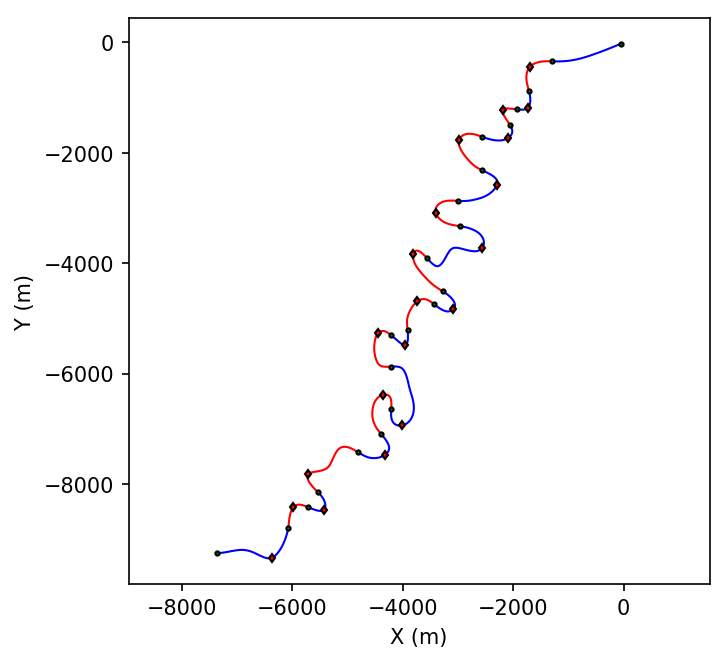

In [4]:
domain=[[],[]]          # plotting area ((xmin, xmax), (ymin, ymax)) - use default pyplot values if the lists are empty 
plot_apex = True        # plot apex points
plot_inflex = True      # plot inflection points
plot_middle = False     # plot middle of inflection points
plot_centroid = False   # plot the centroid of the bend
plot_apex_proba = False # plot apex probability using colorscale
plot_normal = False     # plot the normal to the channel at each channel point
scale_normal = 1.       # if plot_normal is True, scaling parameter for arraows

annotate = False     # write bend id
annot_text_size = 10 # annotation text size
color_bend = True    # color bend path in blue and red according to curvature
linewidth = 1        # centerline width
markersize = 2       # apex, inflection, middle point marker size

plot_filename = input_file_name[:-4] + ".png" # to save plot figure

fig, ax = plt.subplots(figsize=(5,5), dpi=150)   
plot.plot_bends(ax, (centerline.cl_points,), centerline.bends, domain = domain, annotate = annotate,
           plot_apex = plot_apex, plot_inflex = plot_inflex, plot_middle = plot_middle,
           plot_centroid = plot_centroid, plot_apex_proba = plot_apex_proba,
           plot_normal = plot_normal, scale_normal = scale_normal,
           annot_text_size = annot_text_size, color_bend = color_bend, 
           alpha=1, cl_color=False, plot_vel_perturb=False)

if len(domain[0]) > 0:
    plt.xlim(domain[0])
if len(domain[1]) > 0:
    plt.ylim(domain[1])
if len(domain[0])+len(domain[1]) == 0:
    plt.axis('equal')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.savefig(working_dir + plot_filename, dpi = 150)
plt.show()